Evaluation on t >= 5 (same segment for fairness)

Naive          RMSE: 1.9778871630351227  MAE: 1.5563666162917738
Moving Average RMSE: 1.215763794567451  MAE: 0.9612186728732951
Linear Reg     RMSE: 1.262720333863144  MAE: 1.0143119448898692
Kalman Filter  RMSE: 1.1192015205350376  MAE: 0.8946531038013023


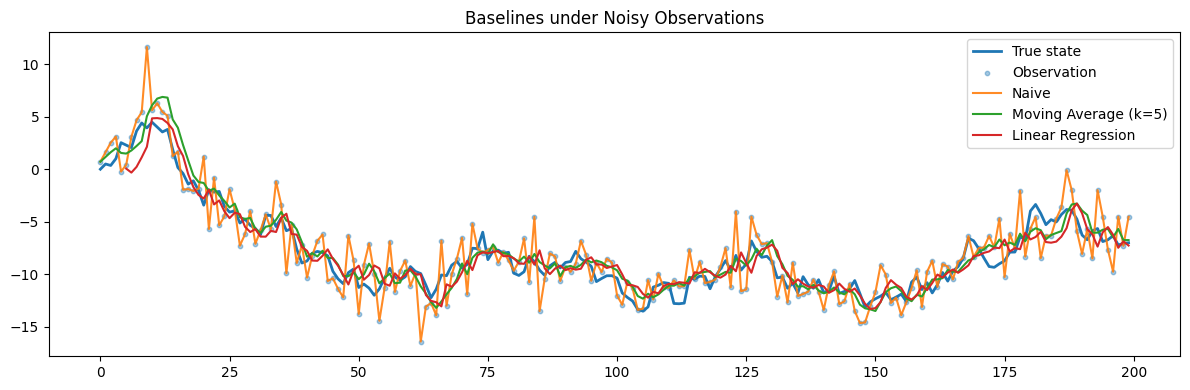

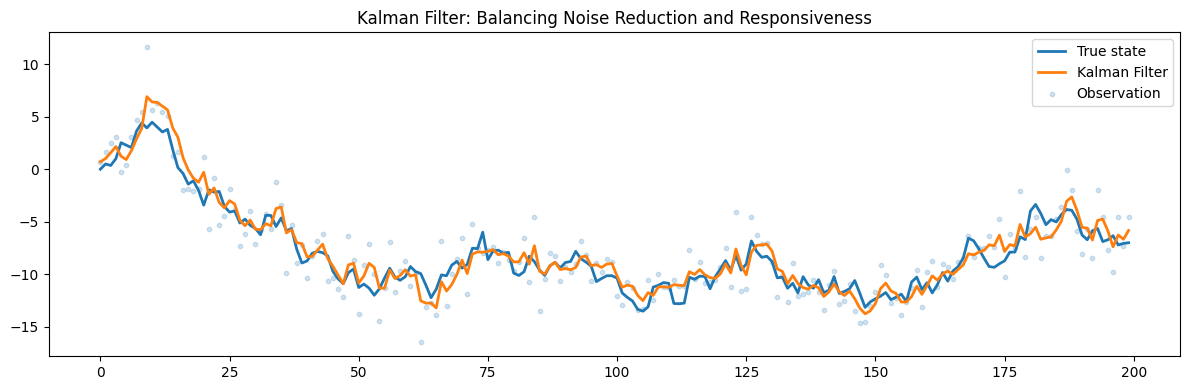

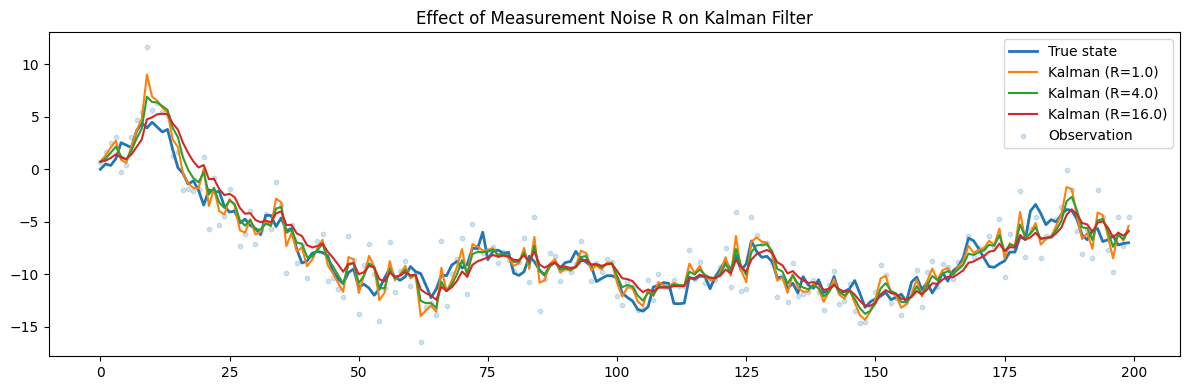

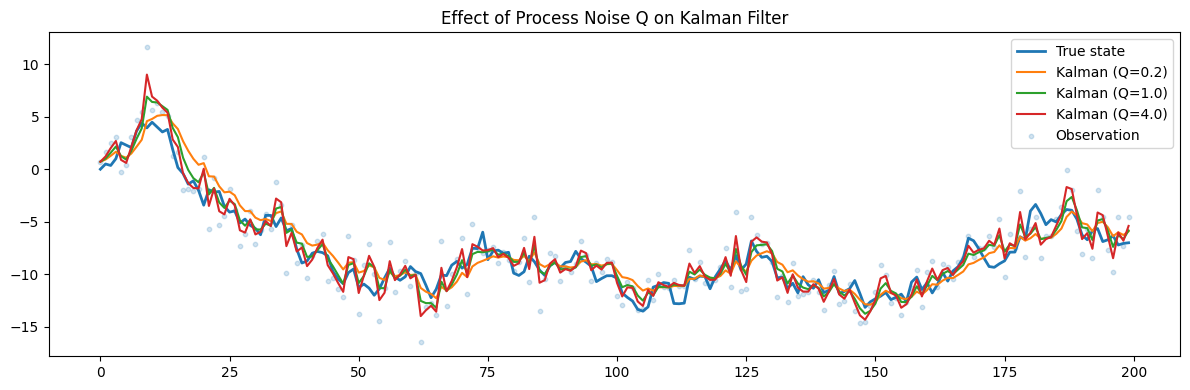

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


# -------------------------
# 1) 設定參數
# -------------------------
T = 200
x0 = 0.0
Q = 1.0
R = 4.0
seed = 42

np.random.seed(seed)

# -------------------------
# 2) 生成 hidden state x_t（random walk）
# -------------------------
w = np.random.normal(0.0, np.sqrt(Q), size=T)
x = np.zeros(T)
x[0] = x0
for t in range(1, T):
    x[t] = x[t-1] + w[t-1]

# -------------------------
# 3) 生成 observation y_t
# -------------------------
v = np.random.normal(0.0, np.sqrt(R), size=T)
y = x + v

# -------------------------
# Baseline 1: Naive
# -------------------------
x_hat_naive = y.copy()

# -------------------------
# Baseline 2: Moving Average
# -------------------------
def moving_average(y, k):
    """
    y: observation array
    k: window size
    return: moving average estimate
    """
    x_hat = np.zeros_like(y)

    for t in range(len(y)):
        # 使用目前時間 t 之前最多 k 個觀測值
        x_hat[t] = np.mean(y[max(0, t-k+1):t+1])

    return x_hat

k = 5
x_hat_ma = moving_average(y, k)

# -------------------------
# Baseline 3: Linear Regression
# -------------------------
def build_regression_data(y, k):
    """
    Build regression dataset:
    X[t] = [y_{t-1}, y_{t-2}, ..., y_{t-k}]
    target[t] = x_t (true state)
    """
    X = []
    target = []

    for t in range(k, len(y)):
        X.append(y[t-k:t][::-1])  # past k observations
        target.append(x[t])       # true state

    return np.array(X), np.array(target)

def kalman_filter_1d_random_walk(y, Q, R, x0_hat=None, P0=1.0):
    """
    1D Kalman filter for:
        x_t = x_{t-1} + w_{t-1},   w ~ N(0, Q)
        y_t = x_t + v_t,          v ~ N(0, R)

    Returns:
        x_hat: posterior estimate x_{t|t}
        P:     posterior uncertainty P_{t|t}
        K:     Kalman gain over time
    """
    T = len(y)
    x_hat = np.zeros(T)
    P = np.zeros(T)
    K_hist = np.zeros(T)

    # initialization
    x_hat[0] = y[0] if x0_hat is None else x0_hat
    P[0] = P0

    for t in range(1, T):
        # ---------- Prediction ----------
        x_pred = x_hat[t-1]
        P_pred = P[t-1] + Q

        # ---------- Update ----------
        K = P_pred / (P_pred + R)
        x_hat[t] = x_pred + K * (y[t] - x_pred)
        P[t] = (1 - K) * P_pred
        K_hist[t] = K

    return x_hat, P, K_hist

def rmse(x_true, x_est):
    return np.sqrt(np.mean((x_true - x_est) ** 2))

def mae(x_true, x_est):
    return np.mean(np.abs(x_true - x_est))


X_reg, y_reg = build_regression_data(y, k)

model = LinearRegression()
model.fit(X_reg, y_reg)

x_hat_reg = np.zeros_like(x)
x_hat_reg[:k] = np.nan
x_hat_reg[k:] = model.predict(X_reg)

x_hat_kf, P_kf, K_kf = kalman_filter_1d_random_walk(y, Q, R, P0=1.0)

R_list = [1.0, 4.0, 16.0]   # 觀測從準 → 吵
Q_list = [0.2, 1.0, 4.0]   # 系統從穩 → 亂
R_fixed = 4.0
Q_fixed = 1.0


valid = ~np.isnan(x_hat_reg)  # 只取 regression 有預測的部分 (t >= k)

rmse_reg = rmse(x[valid], x_hat_reg[valid])
mae_reg  = mae(x[valid], x_hat_reg[valid])


rmse_naive = rmse(x[valid], x_hat_naive[valid])
mae_naive  = mae(x[valid], x_hat_naive[valid])

rmse_ma = rmse(x[valid], x_hat_ma[valid])
mae_ma  = mae(x[valid], x_hat_ma[valid])

rmse_kf = rmse(x[valid], x_hat_kf[valid])
mae_kf  = mae(x[valid], x_hat_kf[valid])

print(f"Evaluation on t >= {k} (same segment for fairness)\n")

print("Naive          RMSE:", rmse_naive, " MAE:", mae_naive)
print("Moving Average RMSE:", rmse_ma,    " MAE:", mae_ma)
print("Linear Reg     RMSE:", rmse_reg,   " MAE:", mae_reg)
print("Kalman Filter  RMSE:", rmse_kf,    " MAE:", mae_kf)



# -------------------------
# Visualization
# -------------------------
t_idx = np.arange(T)

plt.figure(figsize=(12, 4))
plt.plot(t_idx, x, label="True state", linewidth=2)
plt.scatter(t_idx, y, s=10, alpha=0.4, label="Observation")
plt.plot(t_idx, x_hat_naive, label="Naive",alpha=0.9)
plt.plot(t_idx, x_hat_ma, label=f"Moving Average (k={k})")
plt.plot(t_idx, x_hat_reg, label="Linear Regression")
plt.legend()
plt.title("Baselines under Noisy Observations")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,4))
plt.plot(x, label="True state", linewidth=2)
plt.plot(x_hat_kf, label="Kalman Filter", linewidth=2)
plt.scatter(range(T), y, s=10, alpha=0.2, label="Observation")
plt.legend()
plt.title("Kalman Filter: Balancing Noise Reduction and Responsiveness")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,4))
plt.plot(x, label="True state", linewidth=2)

for R_test in R_list:
    x_hat_kf, _, K_kf = kalman_filter_1d_random_walk(y, Q_fixed, R_test)
    plt.plot(x_hat_kf, label=f"Kalman (R={R_test})")

plt.scatter(range(len(y)), y, s=10, alpha=0.2, label="Observation")
plt.legend()
plt.title("Effect of Measurement Noise R on Kalman Filter")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,4))
plt.plot(x, label="True state", linewidth=2)

for Q_test in Q_list:
    x_hat_kf, _, K_kf = kalman_filter_1d_random_walk(y, Q_test, R_fixed)
    plt.plot(x_hat_kf, label=f"Kalman (Q={Q_test})")

plt.scatter(range(len(y)), y, s=10, alpha=0.2, label="Observation")
plt.legend()
plt.title("Effect of Process Noise Q on Kalman Filter")
plt.tight_layout()
plt.show()
